# 自然语言推断：使用注意力
## 模型

In [33]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

### 注意（Attending）


In [34]:
'''
num_inputs：输入特征维度
num_hiddens：隐藏层维度（两层使用相同维度）
flatten：布尔值，是否添加展平层（处理多维输入时）
'''
def mlp(num_inputs, num_hiddens, flatten):
    # 1. 初始化层列表：用Python列表临时存储网络层，最后统一转换为nn.Sequential
    net = []
    '''
    2. 第一层：输入→隐藏层
    Dropout(0.2)：防止过拟合，训练时随机屏蔽20%的输入特征
    Linear：第一个全连接层，将输入映射到隐藏空间
    ReLU：非线性激活函数，增加模型表达能力
    Flatten：如果输入是多维张量（如(batch,seq_len,dim)），从第1维开始展平为(batch,-1)
    '''
    net.append(nn.Dropout(0.2)) # Dropout: 随机失活20%
    net.append(nn.Linear(num_inputs, num_hiddens)) # 全连接层
    net.append(nn.ReLU()) # ReLU激活
    if flatten:
        net.append(nn.Flatten(start_dim=1)) # 可选：展平操作
    # 3. 第二层：隐藏层→隐藏层：深层特征提取，增强模型容量
    net.append(nn.Dropout(0.2))
    net.append(nn.Linear(num_hiddens, num_hiddens))
    net.append(nn.ReLU())
    if flatten:
        net.append(nn.Flatten(start_dim=1))
    # 4. 组装成序列模型：返回一个完整的nn.Sequential模型，可像普通模块一样调用
    # *net：将列表解包为位置参数
    return nn.Sequential(*net)

In [35]:
class Attend(nn.Module):
    '''
    1. 参数
        num_inputs：输入特征维度（通常是词嵌入维度embed_size）
        num_hiddens：MLP隐藏层维度，用于计算注意力分数
        flatten=False：保持输出为3D张量（batch,seq_len,hidden），而非展平
    2. self.f 的作用
        存储一个两层的MLP网络
        该网络用于将词嵌入映射到注意力空间
        输入：词嵌入向量
        输出：注意力表示向量（用于后续计算词与词之间的相似度）
    3. 在Decomposable Attention中的位置该模型包含三个主要模块：
        Attend（当前类）：计算软对齐矩阵
        Compare：比较对齐后的表示
        Aggregate：聚合结果进行分类
    '''
    def __init__(self, num_inputs, num_hiddens, **kwargs):
        super(Attend, self).__init__(**kwargs)
        self.f = mlp(num_inputs, num_hiddens, flatten=False)

    def forward(self, A, B):
        '''
        1. 映射到注意力空间：self.f 是两层MLP，将词嵌入从embed_size映射到num_hiddens
        # A/B的形状：（批量大小，序列A/B的词元数，embed_size）
        # f_A/f_B的形状：（批量大小，序列A/B的词元数，num_hiddens）
        '''
        f_A = self.f(A)
        f_B = self.f(B)
        '''
        2. 计算相似度矩阵
        f_B.permute(0,2,1)：将f_B转置为(64, 200, 60)
        torch.bmm：批量矩阵乘法
        输出形状：e为(64, 50, 60)，e的形状：（批量大小，序列A的词元数，序列B的词元数）
            e[i,j,k] 表示前提第j个词与假设第k个词的相似度分数
        '''
        e = torch.bmm(f_A, f_B.permute(0, 2, 1))
        '''
        3. 软对齐：假设→前提
        F.softmax(e,dim=-1)：在最后一个维度归一化，得到注意力权重
        形状：(64,50,60)，每行和为1
        torch.bmm(...,B)：将权重应用于假设B
        输出形状：beta为(64,50,100)
            beta的形状：（批量大小，序列A的词元数，embed_size），意味着序列B被软对齐到序列A的每个词元(beta的第1个维度)
            含义：每个前提词都获得一个加权求和的假设表示，即：假设被软对齐到每个前提词
        '''
        beta = torch.bmm(F.softmax(e, dim=-1), B)
        '''
        4. 软对齐：前提→假设
        e.permute(0,2,1)：转置相似度矩阵为(64,60,50)
        F.softmax(...,dim=-1)：得到前提→假设的注意力权重
        torch.bmm(...,A)  ：将权重应用于前提A
        输出形状：alpha为(64,60,100)
            alpha的形状：（批量大小，序列B的词元数，embed_size），意味着序列A被软对齐到序列B的每个词元(alpha的第1个维度)
            含义：每个假设词都获得一个 加权求和的前提表示，即：前提被软对齐到每个假设词
        '''
        alpha = torch.bmm(F.softmax(e.permute(0, 2, 1), dim=-1), A)
        # beta：(64,50,100)—前提视角的假设对齐表示
        # alpha：(64,60,100)—假设视角的前提对齐表示
        return beta, alpha

### 比较

| 维度索引             | 名称             | 含义              | 示例值           |
| ---------------- | -------------- | --------------- | ------------- |
|  `dim=0` | 批量维度           | 样本数量            | 64            |
| **`dim=1`**      | 序列维度           | 词元数量            | 50（前提长度）      |
| **`dim=2`**  |  嵌入维度  |  词向量大小  |  100  |


```python
单个词元 i 的表示（在维度1的某个位置）：
A[i]      = [a1, a2, a3, ..., a100]          (第一个100维)
beta[i]   = [b1, b2, b3, ..., b100]          (第二个100维)
↓ 沿dim=2拼接
cat[i]    = [a1, a2, ..., a100, b1, b2, ..., b100]  (200维)
```

In [36]:
class Compare(nn.Module):
    '''
    参数说明
        num_inputs：输入特征维度（通常是embed_size*2，因为会拼接原始词嵌入和对齐表示）
        num_hiddens：MLP隐藏层维度，用于学习比较函数
        flatten=False：保持输入的序列维度，输出形状为 (batch,seq_len,hidden)
    self.g的作用
        创建一个两层的MLP网络，专门用于比较（compare）操作
        不同于常规的匹配，这个MLP学习如何组合原始信息和对齐信息，生成更丰富的词元级比较表示
    '''
    def __init__(self, num_inputs, num_hiddens, **kwargs):
        super(Compare, self).__init__(**kwargs)
        self.g = mlp(num_inputs, num_hiddens, flatten=False)
    '''
    前提A: (64, 50, 100)  +  beta: (64, 50, 100)
    ↓ cat
    拼接: (64, 50, 200)
    ↓ self.g
    V_A:   (64, 50, 200)

    假设B: (64, 60, 100)  +  alpha: (64, 60, 100)
    ↓ cat
    拼接: (64, 60, 200)
    ↓ self.g
    V_B:   (64, 60, 200)
    '''
    def forward(self, A, B, beta, alpha):
        '''
        torch.cat([A,beta],dim=2)：沿嵌入维度(2)拼接
            A：前提词的原始语义（自身）
            beta：前提词通过注意力加权的假设信息（对方）
            结果形状：(64,50,200)
        self.g：调用两层MLP，输出比较特征
            V_A 形状：(64,50,num_hiddens)，每个前提词得到融合了对齐假设的表示
        '''
        V_A = self.g(torch.cat([A, beta], dim=2))
        # V_B 形状：(64,60,num_hiddens)
        V_B = self.g(torch.cat([B, alpha], dim=2))
        return V_A, V_B

### 聚合


| 方法                | 操作  | 优点       | 缺点       |
| ----------------- | --- | -------- | -------- |
| **`sum(dim=1)`**  | 求和  | 保留所有信息   | 对长序列数值较大 |
| **`mean(dim=1)`** | 平均  | 对序列长度不敏感 | 弱化重要词元   |
| **`max(dim=1)`**  | 取最大 | 突出显著特征   | 丢失大部分信息  |


```python
前提: "A man is walking"
前提词元:  [A,    man,   is,   walking, <pad>, ..., <pad>]
           └────────────────────────────────┘
           共50个位置 (seq_len=50)

经过 Compare 后:
V_A = [v_1, v_2, v_3, v_4, v_5, ..., v_50]  # 每个v_i是200维向量

求和聚合:
句子表示 = v_1 + v_2 + v_3 + v_4 + v_5 + ... + v_50
         = [200维特征总和]
```

In [37]:
class Aggregate(nn.Module):
    '''
    num_inputs：输入维度，通常是num_hiddens*2（两路特征拼接后）
    num_hiddens：MLP隐藏层维度
    num_outputs：输出类别数，SNLI任务为3（蕴含/矛盾/中性）
    self.h：两层的MLP，用于提取高级特征
    self.linear：最终分类层，输出logits
    '''
    def __init__(self, num_inputs, num_hiddens, num_outputs, **kwargs):
        super(Aggregate, self).__init__(**kwargs)
        self.h = mlp(num_inputs, num_hiddens, flatten=True)
        self.linear = nn.Linear(num_hiddens, num_outputs)

    def forward(self, V_A, V_B):
        '''
        # 对两组比较向量分别求和
        1. 序列维度求和（关键聚合操作）
        V_A：(batch,premise_len,num_hiddens)，如(64,50,200)
        V_B：(batch,hypothesis_len,num_hiddens)，如(64,60,200)
        sum(dim=1)：沿序列长度维度求和
        结果：
            V_A→(64,200)（所有前提词元信息的总和）
            V_B→(64,200)（所有假设词元信息的总和）
        作用：将变长序列压缩为定长向量，实现序列不变性
        '''
        V_A = V_A.sum(dim=1)
        V_B = V_B.sum(dim=1)
        '''
        # 将两个求和结果的连结送到多层感知机中
        2. 拼接两路特征
        结果形状：(batch,num_hiddens*2)，如 (64,400)
        意义：将前提和假设的最终表示拼接，作为分类依据
        3. 分类
        self.h：MLP提取非线性特征，输出 (batch,num_hiddens)
        self.linear：映射到3个类别输出 (batch,3)
        Y_hat：未归一化的logits，后续配合CrossEntropyLoss使用
        '''
        Y_hat = self.linear(self.h(torch.cat([V_A, V_B], dim=1)))
        return Y_hat

### 整合代码

| 参数                       | 含义              | 典型值                   |
| ------------------------ | --------------- | --------------------- |
| **`vocab`**              | 词汇表对象           | -                     |
| **`embed_size`**     | **词嵌入维度**       | **100**               |
| **`num_hiddens`**   | **各模块MLP隐藏层维度** | **200**               |
| **`num_inputs_attend`**  | Attend模块输入维度    | 100（等于embed\_size）    |
| **`num_inputs_compare`** | Compare模块输入维度   | 200（等于embed\_size×2）  |
| **`num_inputs_agg`**     | Aggregate输入维度   | 400（等于num\_hiddens×2） |


In [38]:
'''
前提索引: (64, 50) → Embedding → A: (64, 50, 100)
假设索引: (64, 60) → Embedding → B: (64, 60, 100)
   ↓ Attend
beta: (64, 50, 100)  α: (64, 60, 100)

   ↓ Compare (拼接[原始;对齐])
V_A: (64, 50, 200)  V_B: (64, 60, 200)

   ↓ Aggregate (sum+concat)
logits: (64, 3)
'''
class DecomposableAttention(nn.Module):
    def __init__(self, vocab, embed_size, num_hiddens, num_inputs_attend=100,
                 num_inputs_compare=200, num_inputs_agg=400, **kwargs):
        super(DecomposableAttention, self).__init__(**kwargs)
        # 1. 词嵌入层：将词索引映射为稠密向量（如(batch,50)→(batch,50,100)）
        self.embedding = nn.Embedding(len(vocab), embed_size)
        # 2. Attend模块：计算软对齐矩阵，让前提和假设的词元互相"关注"
        # 输入维度：embed_size(100)；隐藏维度：num_hiddens(200)
        self.attend = Attend(num_inputs_attend, num_hiddens)
        # 3. Compare模块：对每个词元，比较其原始嵌入与对齐表示
        # 输入维度：embed_size×2(200)，因为会拼接[原始;对齐]
        self.compare = Compare(num_inputs_compare, num_hiddens)
        # 4. Aggregate模块：将词元级特征聚合成句子级向量，并分类
        # 输入维度：num_hiddens×2(400)，因为会拼接前提和假设的聚合向量；输出维度：3（SNLI三分类：蕴含/矛盾/中性）
        self.aggregate = Aggregate(num_inputs_agg, num_hiddens, num_outputs=3)

    def forward(self, X):
        premises, hypotheses = X
        # 1. 词嵌入
        A = self.embedding(premises) # (batch,premise_len,embed_size)
        B = self.embedding(hypotheses) # (batch,hypothesis_len,embed_size)
        '''
        2. 软对齐（Attend）
        beta：每个前提词融合对齐的假设信息
        alpha：每个假设词融合对齐的前提信息
        '''
        beta, alpha = self.attend(A, B)
        '''
        3. 比较（Compare）
        V_A：前提词元级的比较特征
        V_B：假设词元级的比较特征
        '''
        V_A, V_B = self.compare(A, B, beta, alpha)
        # 4. 聚合与分类（Aggregate）：Y_hat：三分类的logits
        Y_hat = self.aggregate(V_A, V_B)
        return Y_hat

In [41]:
# data_dir：数据集目录路径；is_train：True读取训练集，False读取测试集
# 返回：(premises,hypotheses,labels)三个列表
#@save
def read_snli(data_dir=None, is_train=True):
    """将SNLI数据集解析为前提、假设和标签

    如果未提供 data_dir，会尝试使用 `extract_dir` 全局变量；若不存在则调用 `d2l.download_extract('SNLI')`。
    函数会在打开 TSV 文件前尝试清理目录中的无效文件（如包含 '\r' 的文件名），并在打开失败时重试一次。
    """
    # 1. 文本清洗函数：清理文本中的括号和冗余空格
    def extract_text(s):
        # 删除我们不会使用的信息
        s = re.sub('\\(', '', s) # 删左括号
        s = re.sub('\\)', '', s) # 删右括号
        # 用一个空格替换两个或多个连续的空格
        s = re.sub('\\s{2,}', ' ', s) # 两个以上空格合并为一个
        return s.strip()
    
    '''
    2. 标签映射：将文本标签转为整数
    'entailment'（蕴含）→0
    'contradiction'（矛盾）→1
    'neutral'（中性）→2
    SNLI中有些样本标记为'-'（问题样本），将被过滤掉
    '''
    label_set = {'entailment': 0, 'contradiction': 1, 'neutral': 2}
    '''
    3. 文件读取与解析
    选择文件：根据is_train选择训练集或测试集
    读取TSV：按制表符分割每行，readlines()[1:]跳过CSV表头
    结果：rows是一个二维列表，每行是一个字段列表
    '''
    # 确保 data_dir 可用
    if data_dir is None:
        try:
            data_dir = extract_dir
        except NameError:
            data_dir = d2l.download_extract('SNLI')
    # 尝试清理目录以删除可能导致 Windows 报错的文件
    try:
        _cleanup_snli_dir(data_dir)
    except Exception:
        pass
    file_name = os.path.join(data_dir, 'snli_1.0_train.txt' if is_train else 'snli_1.0_test.txt')
    try:
        with open(file_name, 'r') as f:
            rows = [row.split('\t') for row in f.readlines()[1:]]
    except Exception as e:
        # 若因目录中存在无效文件名导致打开失败，先尝试清理目录后重试
        print(f'打开 {file_name} 失败: {e}. 尝试清理目录并重试。')
        try:
            _cleanup_snli_dir(data_dir)
            with open(file_name, 'r') as f:
                rows = [row.split('\t') for row in f.readlines()[1:]]
        except Exception as e2:
            raise RuntimeError(f'无法打开文件 {file_name}，请检查 SNLI 数据集是否正确解压到 {data_dir}，或手动删除目录中异常文件。 原始错误: {e2}')
    '''
    4. 数据提取与过滤
    row[0]：标签列（如'entailment'），不在label_set中的行被跳过
    row[1]：前提（premise）句子
    row[2]：假设（hypothesis）句子
    列表推导式：只保留标签有效的样本，确保数据质量
    '''
    premises = [extract_text(row[1]) for row in rows if row[0] in label_set]
    hypotheses = [extract_text(row[2]) for row in rows if row[0] \
                in label_set]
    labels = [label_set[row[0]] for row in rows if row[0] in label_set]
    '''
    premises：字符串列表，如['A man inspects...',...]
    hypotheses：字符串列表，如['An activity is being...',...]
    labels：整数列表，如[0,1,2,0,...]
    '''
    return premises, hypotheses, labels

In [49]:
#@save
class SNLIDataset(torch.utils.data.Dataset):
    """用于加载SNLI数据集的自定义数据集"""
    '''
    dataset：元组 (premises,hypotheses,labels)，来自read_snli()的输出
    num_steps：序列最大长度（填充/截断的目标长度）
    vocab：可选的预构建词汇表（用于共享训练/测试集词表）
    '''
    def __init__(self, dataset, num_steps, vocab=None):
        # 1. 设置序列长度：保存最大序列长度，供后续填充/截断使用
        self.num_steps = num_steps
        '''
        2. 分词处理
        dataset[0]：前提（premise）字符串列表
        dataset[1]：假设（hypothesis）字符串列表
        tokenize：将每个句子字符串拆分为单词列表（如['a','man','is',...]）
        '''
        all_premise_tokens = d2l.tokenize(dataset[0])
        all_hypothesis_tokens = d2l.tokenize(dataset[1])
        '''
        3. 构建或复用词汇表
        首次调用（如训练集）：合并所有前提和假设的词元，构建新词表
            min_freq=5：过滤低频词（出现<5次的词映射为<unk>）
            reserved_tokens=['<pad>']：添加填充符
        后续调用（如测试集）：复用训练集词表，确保索引一致
        '''
        if vocab is None:
            self.vocab = d2l.Vocab(all_premise_tokens + \
                all_hypothesis_tokens, min_freq=5, reserved_tokens=['<pad>'])
        else:
            self.vocab = vocab
        '''
        4. 序列填充/截断
        _pad方法（未显示但可推断）：
            将每个词元列表转换为索引序列（通过vocab）
            长度>num_steps：截断尾部
            长度<num_steps：用<pad>索引填充
        结果：self.premises和self.hypotheses是形状为(样本数,num_steps)的张量列表
        '''
        self.premises = self._pad(all_premise_tokens)
        self.hypotheses = self._pad(all_hypothesis_tokens)
        # 5. 标签张量化：dataset[2]：原始整数标签列表（0/1/2），转换为PyTorch张量，便于后续训练和计算损失
        self.labels = torch.tensor(dataset[2])
        # 6. 打印统计信息
        print('read ' + str(len(self.premises)) + ' examples')
    '''
    1. 输入：lines
    类型：词元列表的列表（nested list）
    示例：[['a','man','is','walking'],['the','dog','barks'],...]；每个子列表代表一个句子的单词分词结果
    2. 词元→索引转换：self.vocab[line]
    调用词汇表将每个词元字符串映射为整数索引；示例：['a','man','is']→[12,85,7]
    OOV处理：不在词表中的词映射为<unk>的索引
    3. 截断与填充：d2l.truncate_pad(...,self.num_steps,self.vocab['<pad>'])
    self.num_steps：目标固定长度（如50）
    self.vocab['<pad>']：填充符的索引（通常是0）
    逻辑：
        序列长度>num_steps：截断尾部，只保留前num_steps个词
        序列长度<num_steps：在末尾补填充符，直到长度为num_steps
    4. 转换为张量：torch.tensor([... for line in lines])
    列表推导式遍历所有句子
    最终返回二维张量，形状：(句子数量,num_steps)
    '''
    def _pad(self, lines):
        return torch.tensor([d2l.truncate_pad(
            self.vocab[line], self.num_steps, self.vocab['<pad>'])
                         for line in lines])
    # 特殊方法：当使用dataset[i]访问元素时自动调用
    # idx：要获取的样本索引（整数，如0,1,2...）
    def __getitem__(self, idx):
        '''
        返回一个嵌套元组：((premise,hypothesis),label)
        self.premises[idx]：第idx个前提句子的张量
            形状：(num_steps,)，如tensor([12,85,7,33,0,0,...])
        self.hypotheses[idx]：第idx个假设句子的张量
            形状：(num_steps,)，与前提格式相同
        self.labels[idx]：第idx个样本的标签
            类型：torch.tensor(0)或tensor(1)或tensor(2)
            对应关系：0=蕴含(entailment),1=矛盾(contradiction),2=中性(neutral)
        '''
        return (self.premises[idx], self.hypotheses[idx]), self.labels[idx]
    # 数据集的总样本数
    def __len__(self):
        return len(self.premises)

## 训练和评估模型

现在，我们将在SNLI数据集上对定义好的可分解注意力模型进行训练和评估。我们从读取数据集开始。

### 读取数据集

我们使用`sec_natural-language-inference-and-dataset`中定义的函数下载并读取SNLI数据集。批量大小和序列长度分别设置为$256$和$50$。


In [50]:
# batch_size：每个训练批次的样本数量
# num_steps：序列最大长度（默认50），用于填充/截断句子
import os
import re
#@save
def load_data_snli(batch_size, num_steps=50):
    """下载SNLI数据集并返回数据迭代器和词表"""
    # 1. 设置多进程加载
    # num_workers = d2l.get_dataloader_workers()
    num_workers = 0
    # 2. 下载数据集
    # data_dir = d2l.download_extract('SNLI')
    data_dir = '..\\data\\snli_1.0'
    # 3. 读取原始数据
    train_data = read_snli(data_dir, True) # 训练集，(premises,hypotheses,labels)元组
    test_data = read_snli(data_dir, False) # 测试集，(premises,hypotheses,labels)元组
    # 4. 创建数据集对象
    train_set = SNLIDataset(train_data, num_steps)
    test_set = SNLIDataset(test_data, num_steps, train_set.vocab)
    '''
    5. 创建数据迭代器
    train_iter：shuffle=True：打乱数据顺序，确保每轮训练顺序不同，用于模型训练
    test_iter：shuffle=False：保持原始顺序，便于复现评估结果，用于模型验证/测试
    '''
    train_iter = torch.utils.data.DataLoader(train_set, batch_size,
                                             shuffle=True,
                                             num_workers=num_workers)
    test_iter = torch.utils.data.DataLoader(test_set, batch_size,
                                            shuffle=False,
                                            num_workers=num_workers)
    '''
    train_iter：训练数据迭代器
    test_iter：测试数据迭代器
    train_set.vocab：词汇表对象（后续可用于词向量加载或解码）
    '''
    return train_iter, test_iter, train_set.vocab

In [51]:
batch_size, num_steps = 256, 50
train_iter, test_iter, vocab = load_data_snli(batch_size, num_steps)

read 549367 examples
read 9824 examples


### 创建模型


| 组件                         | 形状              | 说明              |
| -------------------------- | --------------- | --------------- |
| **`len(vocab)`**           | 18678           | 词汇表大小（过滤低频词后）   |
| **`embed_size`**           | 100             | 嵌入维度            |
| **`net.embedding.weight`** | `(18678, 100)`  | 待初始化的嵌入层权重      |
| **`glove_embedding`**      | `(400000, 100)` | GloVe原始词表（40万词） |
| **`embeds`**               | `(18678, 100)`  | 提取的子集，完美匹配模型权重  |


In [52]:
'''
1. 设置超参数和计算设备
embed_size=100：词嵌入维度，匹配GloVe预训练向量维度
num_hiddens=200：模型中MLP隐藏层维度
d2l.try_all_gpus()：返回所有可用的GPU设备列表（如[cuda:0,cuda:1]），用于后续多GPU训练
'''
embed_size, num_hiddens, devices = 100, 200, d2l.try_all_gpus()
'''
2. 实例化模型
vocab：词汇表对象（大小约1.8万）
embed_size=100：嵌入层输出维度
num_hiddens=200：各模块MLP的隐藏层维度
初始状态：嵌入层权重是随机初始化的
'''
net = DecomposableAttention(vocab, embed_size, num_hiddens)
'''
3. 加载GloVe预训练向量
下载/加载GloVe预训练模型
'glove.6b.100d'：
    在60亿词上训练
    每个词向量100维
    词汇量约40万词
'''
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
'''
4. 提取词汇表对应的向量
vocab.idx_to_token：模型词汇表中所有词元（列表，长度=18678）
批量查询：一次性获取所有词元的GloVe向量
结果形状：embeds的形状为(18678,100)，与模型嵌入层权重形状一致
'''
embeds = glove_embedding[vocab.idx_to_token]
'''
5. 复制预训练权重到模型
net.embedding.weight：模型嵌入层的权重矩阵，形状(18678,100)
.data.copy_(embeds)：
    原地复制：将随机初始化的权重替换为GloVe预训练向量
    冻结？：这里没有冻结（requires_grad=True），模型会继续微调这些向量
    分号;：在Jupyter中抑制不必要的输出，让界面更整洁
'''
net.embedding.weight.data.copy_(embeds);

### 训练和评估模型


现在我们可以在SNLI数据集上训练和评估模型。


loss 0.498, train acc 0.804, test acc 0.823
21952.2 examples/sec on [device(type='cuda', index=0)]


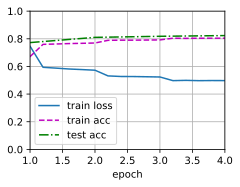

In [53]:
lr, num_epochs = 0.001, 4
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
    devices)

### 使用模型

最后，定义预测函数，输出一对前提和假设之间的逻辑关系。


In [54]:
#@save
def predict_snli(net, vocab, premise, hypothesis):
    """预测前提和假设之间的逻辑关系"""
    # 1. 设置模型为评估模式
    net.eval()
    '''
    2. 文本 → 词元索引转换
    vocab[premise]：将前提句子分词后转换为索引列表
    torch.tensor(...)：转换为PyTorch张量
    device=d2l.try_gpu()：自动将数据移动到GPU（如果可用），加速预测
    '''
    premise = torch.tensor(vocab[premise], device=d2l.try_gpu())
    hypothesis = torch.tensor(vocab[hypothesis], device=d2l.try_gpu())
    '''
    3. 调整输入形状
    形状调整：
        premise.reshape((1,-1))：将一维张量转为二维，添加批次维度
        原形状：(seq_len,)
        新形状：(1,seq_len)
        目的：模型期望输入批量数据，即使预测单个样本也需要批次维度
    模型调用：
        net([...,...])：将前提和假设两个张量作为列表传入模型
        匹配forward(self,X)中X=[premises,hypotheses]的格式
        .argmax(dim=1)：在维度1（类别维度）上取最大值索引，得到预测标签
        输出形状：(1,)的整数张量（0,1或2）
    '''
    label = torch.argmax(net([premise.reshape((1, -1)),
                           hypothesis.reshape((1, -1))]), dim=1)
    '''
    4. 标签→文本映射
    label==0→'entailment'（蕴含）
    label==1→'contradiction'（矛盾）
    label==2→'neutral'（中性）
    '''
    return 'entailment' if label == 0 else 'contradiction' if label == 1 \
            else 'neutral'

我们可以使用训练好的模型来获得对示例句子的自然语言推断结果。


In [55]:
predict_snli(net, vocab, ['he', 'is', 'good', '.'], ['he', 'is', 'bad', '.'])

'contradiction'